# Tutorial

This is a short tutorial which demonstrates the meaning of different RVT parameters on test images. The tutorial is also available as a [Jupyter notebook](https://github.com/AlexShkarin/RVT/blob/main/docs/tutorial.ipynb).

## Environment setup

First, we import the libraries and define the auxiliary plotting function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import imgrvt as rvt

def plot_comparison(src, results, titles=None): # plot several images to compare different RVT parameters
    nres=len(results)
    _,axes=plt.subplots(1,nres+1,figsize=(4*nres+4,3))
    axes[0].imshow(src,cmap="gray")
    axes[0].set_title("Source")
    for ax,res,t in zip(axes[1:],results,titles or [None]*nres):
        ax.imshow(res,cmap="inferno")
        if t:
            ax.set_title(t)

## Basic principle

The transform is designed to highlight points of high radial symmetry. It is originally developed for particle localization in microscopic images, where these points correspond to the particle point spread functions (PSFs). These include both simple Gaussian-like PSFs and PSFs with rings, which often show up in interferometric microscopy. The transform is based on analyzing variance of mean pixel values at different distances from the given position (see [paper](https://doi.org/10.1364/OE.420670) for the exact description).

To apply the transform to the image, you simply need to call ``rvt.rvt`` function. The result is an image of the same size (unless [upsampling](#upsampling) is used), in which brightness encodes the degree of radial symmetry. The transform does not directly produce the PSF coordinates, but the PSFs become much more pronounced and compact, and can be localized using any standard method, such as Gaussian fitting or [TrackPy](http://soft-matter.github.io/trackpy).

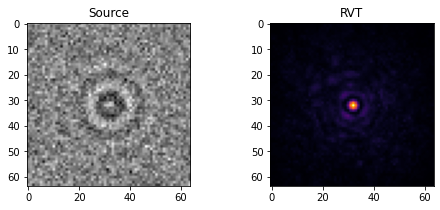

In [2]:
img=rvt.generate.single_ipsf(snr=2)
timg=rvt.rvt(img,rmin=5,rmax=25)
plot_comparison(img,[timg],["RVT"])

## Main parameters

Here we consider the main parameters. We only give the general idea, and to figure out the best parameters it's usually better to just try them on the experimental images and see what looks better.

### Minimal and maximal radius

As with any such transform, we need to specify the characteristic feature size, which is given by the parameter ``rmax``. Typically, it should be the radius where the PSF stops being distinguishable from the noise, although larger or smaller values can also be used depending on the desired speed and precision.

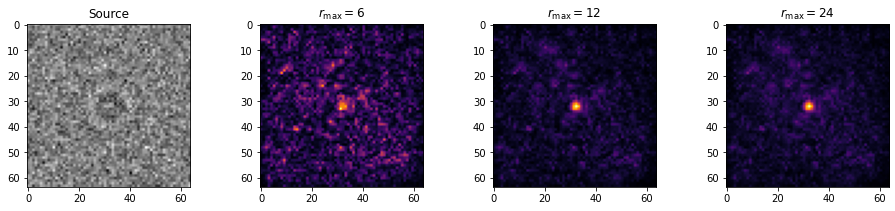

In [3]:
img=rvt.generate.single_ipsf(snr=1)
timgs=[rvt.rvt(img,rmin=2,rmax=rmax) for rmax in [6,12,24]]
plot_comparison(img,timgs,[r"$r_\mathrm{max}=6$",r"$r_\mathrm{max}=12$",r"$r_\mathrm{max}=24$"])

The other important parameter is ``rmin``, which specifies the minimal distance from the center point, for which the pixel value means are calculated. It should be relatively small so that most of the PSF is included between ``rmin`` and ``rmax``. However, since smaller radii consider fewer pixels, ``rmin`` shouldn't be too small, or the image gets noisier.

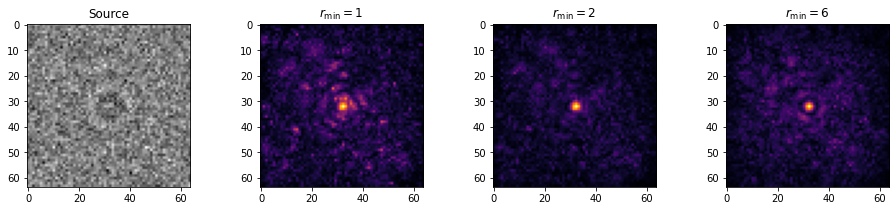

In [4]:
img=rvt.generate.single_ipsf(snr=1)
timgs=[rvt.rvt(img,rmin=rmin,rmax=20) for rmin in [1,2,6]]
plot_comparison(img,timgs,[r"$r_\mathrm{min}=1$",r"$r_\mathrm{min}=2$",r"$r_\mathrm{min}=6$"])

Of course, you should also pay attention to not have ``rmin`` larger than the PSF size

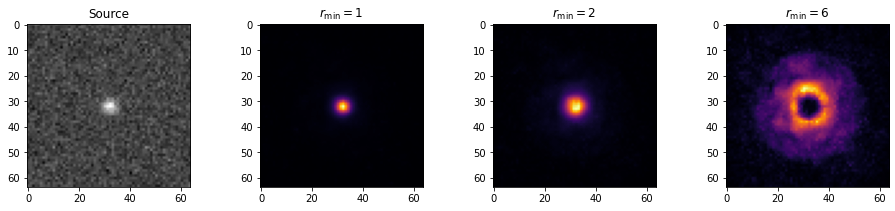

In [5]:
img=rvt.generate.single_gaussian(snr=10,width=2)
timgs=[rvt.rvt(img,rmin=rmin,rmax=20) for rmin in [1,2,6]]
plot_comparison(img,timgs,[r"$r_\mathrm{min}=1$",r"$r_\mathrm{min}=2$",r"$r_\mathrm{min}=6$"])

### Mode

The transform comes in two varieties: basic and normalized, which are specified with the ``kind`` parameter. The normalized version is a bit better at dealing with distorted or overlapping PSFs, and with noisier images. However, it has relatively high subpixel bias, so it's not the best choice for very fine subpixel localization.

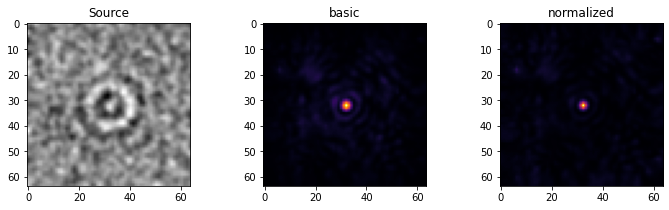

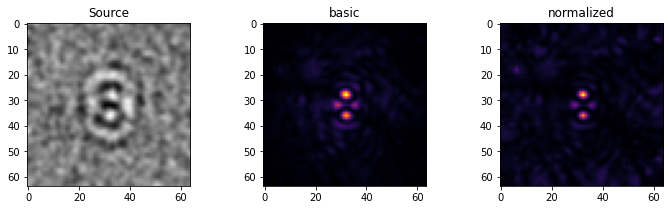

In [6]:
img=rvt.generate.single_ipsf(snr=3,noise_scale=1)
timgs=[rvt.rvt(img,6,20,kind=kind) for kind in ["basic","normalized"]]
plot_comparison(img,timgs,["basic","normalized"])

img=rvt.generate.double_ipsf(snr=3,noise_scale=1,offset=(4,0))
timgs=[rvt.rvt(img,6,20,kind=kind) for kind in ["basic","normalized"]]
plot_comparison(img,timgs,["basic","normalized"])

### High-pass filter
Since RVT relies on large-scale correlations, it is sensitive to low-frequency noise. Therefore, it usually helps to high-pass the image before applying the transform. ``rvt.rvt`` has a built-in Gaussian high-pass filter, whose width is specified by the ``highpass_size`` parameter.

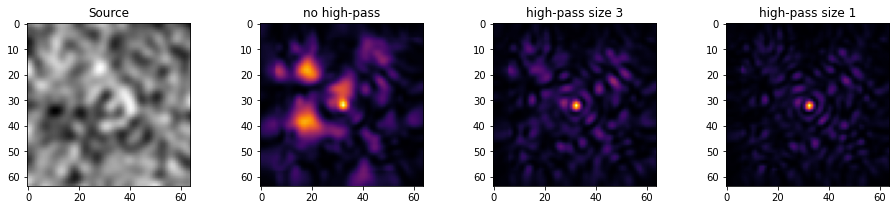

In [7]:
img=rvt.generate.single_ipsf(snr=1,noise_scale=2)
timgs=[rvt.rvt(img,6,20,highpass_size=hps) for hps in [None,3,1]]
plot_comparison(img,timgs,["no high-pass","high-pass size 3","high-pass size 1"])

However, if the presence of high-frequency noise (such as shot noise), it might end up filtering the PSF more than the noise, which reduces the signal-to-noise ratio.

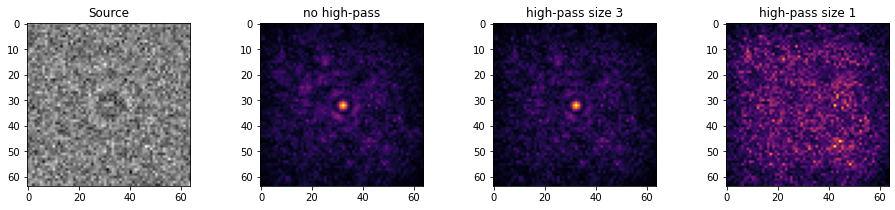

In [8]:
img=rvt.generate.single_ipsf(snr=1)
timgs=[rvt.rvt(img,6,20,highpass_size=hps) for hps in [None,3,1]]
plot_comparison(img,timgs,["no high-pass","high-pass size 3","high-pass size 1"])

### Upsampling
If the PSF has very high spatial frequency, it will become very sharp in the transformed image, down to a single pixel. This negatively affects the subpixel localization precision. Upsampling is designed to mitigate that by increase the image resolution using the nearest-neighbor interpolation. This takes longer to compute, but leads to more precise localization.

Note that the resulting image is larger, so the extracted PSF coordinates need to be converted later as ``original_position=(upsampled_position+0.5)/upsampling-0.5``. The package provides a function ``rvt.convert_upsampled_coordinate`` implementing this conversion.

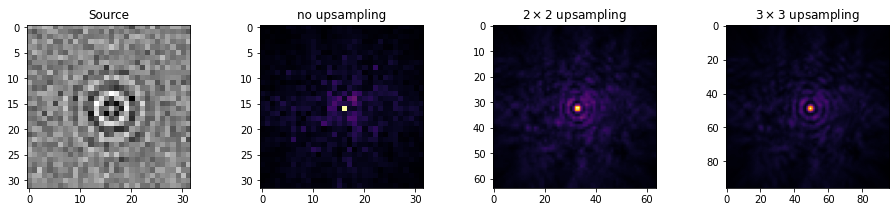

In [9]:
img=rvt.generate.single_ipsf(size=32,snr=5,scale=3,width=5)
timgs=[rvt.rvt(img,6,20,upsample=ups) for ups in [1,2,3]]
plot_comparison(img,timgs,["no upsampling",r"$2\times 2$ upsampling",r"$3\times 3$ upsampling"])

## Additional parameters

### Padding mode

The value of the transformed pixel is affected by all neighboring pixels at the distance up to ``rmax``. Hence, any pixels which are closer than ``rmax`` to the border are affected by the padding strategy. By default, we choose to pad the image with its mean value, which works relatively well, especially in conjunction with high-pass filtering. For other cases different padding modes can be specified with the ``pad_mode`` parameter. The algorithm uses ``np.pad``, so it supports all padding modes taken by this function, such as ``"constant"`` (default), ``"edge"``, ``"reflect"``, etc. It also has a separate "no-padding" ``"fast"`` mode, which is functionally identical to ``"wrap"``, but, depending on the image size and ``rmax``, can be up to 2-3 times faster.

6.77 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.41 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


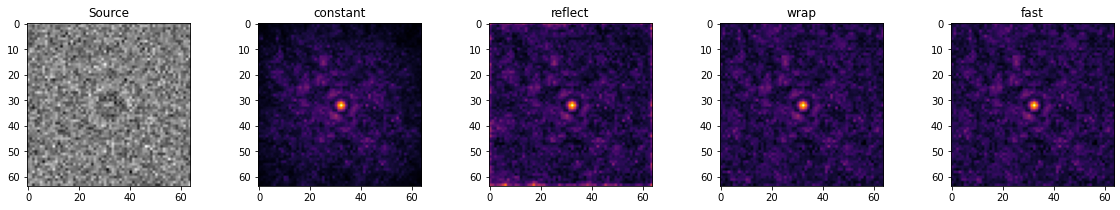

In [10]:
img=rvt.generate.single_ipsf(snr=1)
timgs=[rvt.rvt(img,6,30,pad_mode=pad) for pad in ["constant","reflect","wrap","fast"]]
plot_comparison(img,timgs,["constant","reflect","wrap","fast"])

%timeit rvt.rvt(img,6,30,pad_mode="constant")
%timeit rvt.rvt(img,6,30,pad_mode="fast")

### Coarsening
If run time is an issue, it is possible to trade off localization precision for speed by "coarsening" the analysis. This coarsening is controlled by two parameters: ``coarse_factor`` and ``coarse_mode``. The factor determines how strongly the number of considered radii is reduced. The number of radii and, correspondingly, the runtime is reduced by about ``coarse_factor``. The mode specifies, how exactly the coarsening happens. In the ``"add"`` mode (default) several consecutive radii are merged together, and a single mean value is calculated. This method works better for smoothly-varying PSFs, whose characteristic length is larger than ``coarse_factor``. In the ``"skip"`` mode most of the radii are skipped, and only one every ``coarse_factor`` is used. This is more applicable to high-frequency PSFs.

6.93 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.27 ms ± 62.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


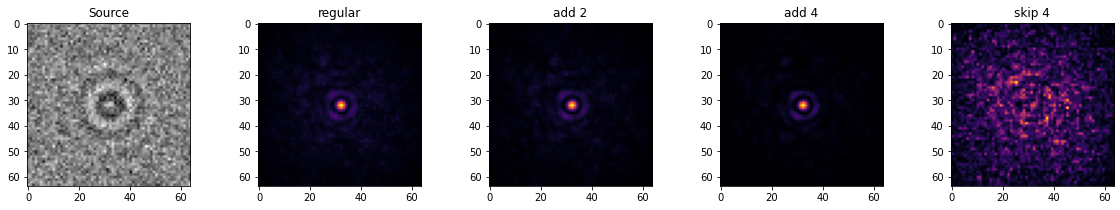

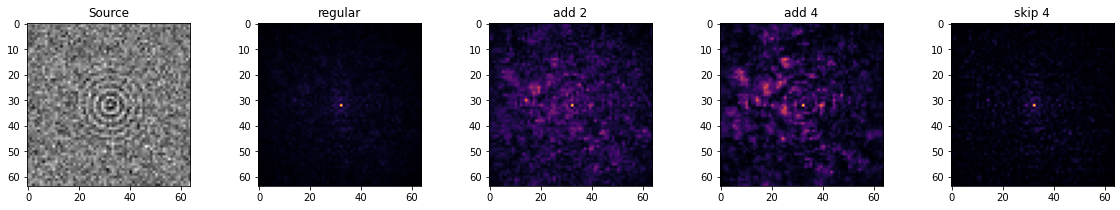

In [11]:
img=rvt.generate.single_ipsf(snr=2)
timgs=[rvt.rvt(img,6,30,coarse_factor=cf,coarse_mode=cm) for (cf,cm) in [(1,"add"),(2,"add"),(4,"add"),(4,"skip")]]
plot_comparison(img,timgs,["regular","add 2","add 4","skip 4"])

img=rvt.generate.single_ipsf(snr=2,scale=3)
timgs=[rvt.rvt(img,6,30,coarse_factor=cf,coarse_mode=cm) for (cf,cm) in [(1,"add"),(2,"add"),(4,"add"),(4,"skip")]]
plot_comparison(img,timgs,["regular","add 2","add 4","skip 4"])

%timeit rvt.rvt(img,6,30)
%timeit rvt.rvt(img,6,30,coarse_factor=4)